In [59]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [60]:
# Get list of fits images in the directory 
image_list = glob.glob("/Users/hwhite/Dropbox/Testdata_Target_E/ASASJ030015-0459.7_20190913_B/*e91.fits.fz")

image_list.sort()

# Let's work with the first one right now
img_path = image_list[9]
hdu = fits.open(img_path)

# Look at what is avaliable in the data.
print(hdu.info())

# Grab the actual science data based on above.
sci_data = hdu[1]

Filename: /Users/hwhite/Dropbox/Testdata_Target_E/ASASJ030015-0459.7_20190913_B/tfn0m414-kb81-20190912-0147-e91.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 CompImageHDU    268   (3054, 2042)   float32   
  2  CAT           1 BinTableHDU    157   43R x 37C   [D, D, D, D, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D]   
  3  BPM           1 CompImageHDU     10   (3054, 2042)   uint8   
None


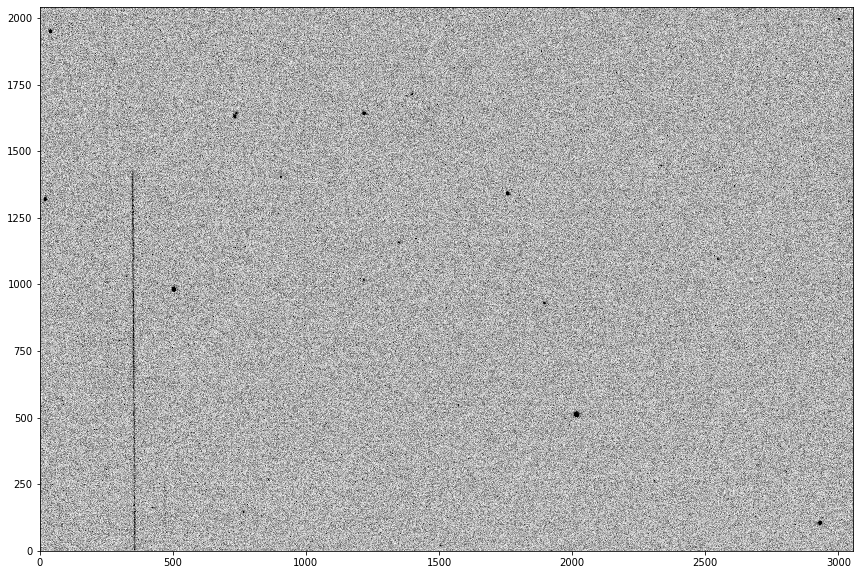

In [61]:
# Always good to start by looking at your data. This top bit just adjusts the scale. 
interval = ZScaleInterval()
vmin = interval.get_limits(sci_data.data)[0]
vmax = interval.get_limits(sci_data.data)[1]

# I prefer black stars on white background. Switch to 'Greys_r' if you prefer the opposite.
plt.figure(figsize=(15, 10))
plt.imshow(sci_data.data, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
plt.show()

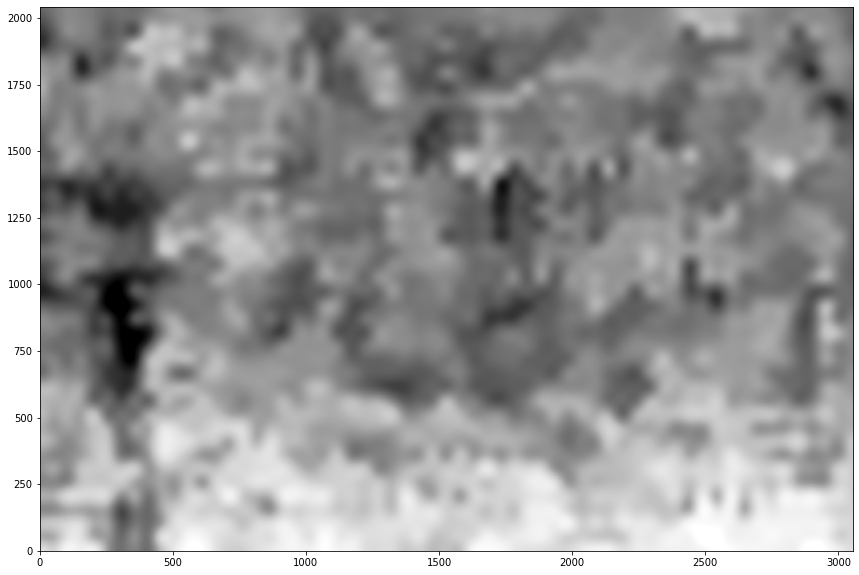

vmax and vmin are 82.08428158580007, 78.28775755431748


In [62]:
# Okay, let's estimate a background. We will eventually subtract this off before we do photometry.

# Background estimation:
sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
bkg = Background2D(
    sci_data.data, (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator)

# Plot the background
interval = ZScaleInterval()
vmin = interval.get_limits(bkg.background)[0]
vmax = interval.get_limits(bkg.background)[1]

# For consistency with above, darker black is "brighter". Use 'Greys_r' for reverse.
plt.figure(figsize=(15, 10))
plt.imshow(bkg.background, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
plt.show()

print('vmax and vmin are {}, {}'.format(vmax,vmin))

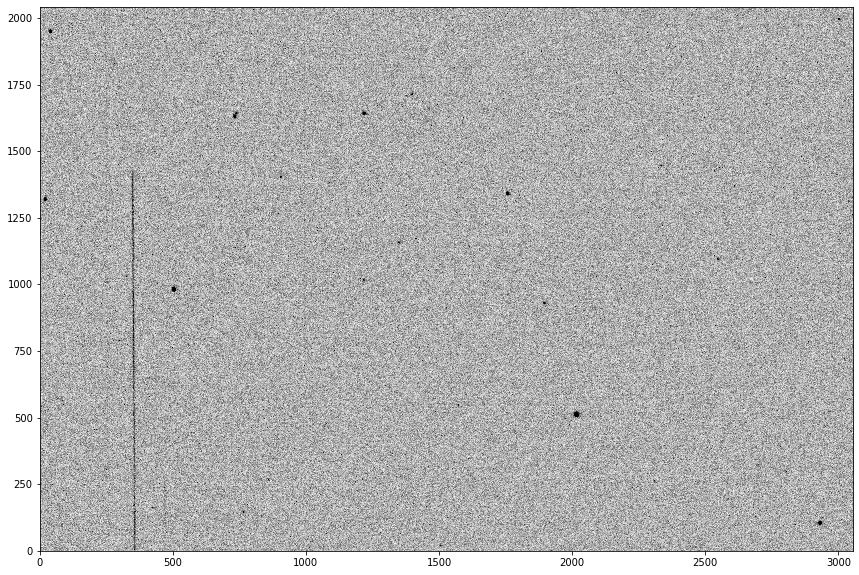

In [63]:
# Now let's subtract the background from the data and see how things look.
sci_bkg = sci_data.data - bkg.background

interval = ZScaleInterval()
vmin = interval.get_limits(sci_bkg)[0]
vmax = interval.get_limits(sci_bkg)[1]

plt.figure(figsize=(15, 10))
plt.imshow(sci_bkg, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
plt.show()

# Note that it doesn't appear much different 
# but if you pay close attention to the noise pattern 
# you can see the bright spots (shown in the bkg estimation) are gone.

In [64]:
# Now let's find some stars within this image.
# For WAISSA we can decide how/if to have them do this. 
# Alternatively, they can just define the "centroids" for the aperatures they want. 
# i.e. have them enter in the pixel coordinates for their star and a handful of standards near their star 
# (which they selected in JS9, for example). 
# That migght be the best.

# But for now, this is how you automatically identify sources:
mean, median, std = sigma_clipped_stats(sci_bkg, sigma=3.0) # calculate a few statistics on the image
daofind = DAOStarFinder(fwhm=4.0, threshold=8.*std)  # identify sources that reach at least 8 * background stddev.
sources = daofind(sci_bkg)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
# Actually print the table of sources in a fancy format so that they can interact with it in the notebook.
sources.show_in_notebook() 

In [65]:
# Now let's find some stars within this image.
# For WAISSA we can decide how/if to have them do this. 
# Alternatively, they can just define the "centroids" for the aperatures they want. 
# i.e. have them enter in the pixel coordinates for their star and a handful of standards near their star 
# (which they selected in JS9, for example). 
# That migght be the best.

#manually set your selected targets from the image
tar_ra = 45.064089
tar_dec = -4.9950228
tar_color = 'yellow'
src_ra = [44.93200, 45.00766, 45.11216, 45.12369, 45.18848]
src_dec = [-5.03533, -4.79669, -4.91007, -4.93852, -4.92924]
src_colors = ['red','cyan', 'green', 'blue', 'magenta']
src_mag = [11.275, 12.093, 13.005, 14.65, 12.177]

w = wcs.WCS(hdu[1].header)

src_xcoords, src_ycoords = w.all_world2pix(src_ra,src_dec,1)
tar_xcoord, tar_ycoord  = w.all_world2pix(tar_ra,tar_dec,1)

print(src_xcoords)
print(src_ycoords)

[2013.18483976  502.34726235 1216.46908865 1396.05002982 1335.74726788]
[ 511.92282253  982.0748155  1643.37343712 1716.73142301 2124.61606176]


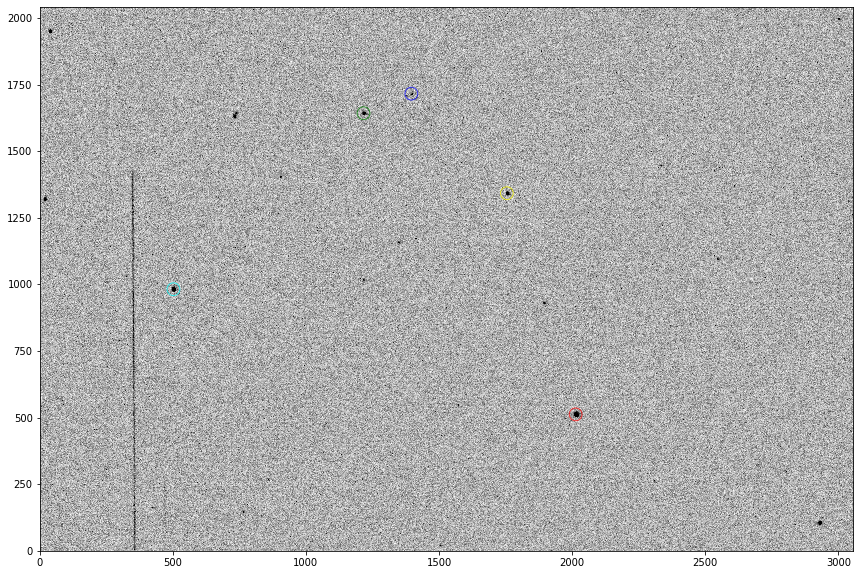

In [66]:
# It found a large number of sources. Let's plot them on the image just to see:
plt.figure(figsize=(15, 10))

for i in range(len((src_colors))):
    positions = np.transpose((src_xcoords[i], src_ycoords[i]))
    apertures = CircularAperture(positions, r=24.)

    apertures.plot(color=src_colors[i], lw=0.9, alpha=0.8)
               
position = np.transpose((tar_xcoord, tar_ycoord))
apertures = CircularAperture(position, r=24.)
apertures.plot(color=tar_color, lw=0.9, alpha=0.8)
               
interval = ZScaleInterval()
vmin = interval.get_limits(sci_bkg)[0]
vmax = interval.get_limits(sci_bkg)[1]
plt.imshow(sci_bkg, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
plt.show()

In [67]:
# Actually do photometry on all of these sources.
# Note that if we would have them only do photometry on a their target and a few well selected standard stars, 
# then they would just have to enter in the positions of those sources here.
# But for now do all the sources it found:

# Define the aperatures photometrty will be performed in.
positions = np.transpose((src_xcoords, src_ycoords))
apertures = CircularAperture(positions, r=24.)

# Define an error image that will be used when calculating photometry
effective_gain = 1.
error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

# Actually do the photometry and put it in a table.
phot = aperture_photometry(sci_bkg, apertures, error=error)

for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output
    
# NOTE. By default photutils just actually gives a total number of counts in the apertures, not a magnitude.
# Calculate instrumental magnitudes here and add them to the table 
# Magnitudes will be calibrated with standard stars below.

zpt_instrumental = 25.
mag = -2.5*np.log10(phot['aperture_sum']) + zpt_instrumental
dmag = (2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum'])
phot['mag'] = mag
phot['mag_err'] = dmag
phot['mag'].info.format= '%.8g'
phot['mag_err'].info.format = '%.8g'

print(list(phot['mag']))

phot.show_in_notebook()

[11.459400300721692, 12.338996272342598, 13.30375461272406, 14.99273008426899, nan]


In [53]:
# Calibrate the photometry
# Calculate zeropoint/offsets based on a set of standard stars.

# NOTE. In order to do this what I did was
# (a) downloaded a set of standard stars within a few arcminutes of the source from APASS.
# (b) picked five of these which were relatively nearby and of a similar magnitude to our source when possible (within DS9).
# (c) KEY: I then manually identified which of the stars these five targets were in the table above and wrote their index number down.
# Clearly this last point isn't ideal, but if they students were only doing photometry of 5-10 sources that they selected 
# anyway, then it isn't too bad.

# Get stars from above.
mag_measured = phot['mag']
mag_known = src_mag

# Calculate offsets and the standard deviation of the offset from each star.
offsets = mag_known - mag_measured
offset = np.mean(offsets)
doffset = np.std(offsets)
# Print the offsets to make sure nothing went wrong.
print(offset,doffset)

print(offsets)

#Add the calibrated photometry to the table:
mag_cal = phot['mag']+offset
dmag_cal = np.sqrt(phot['mag_err']**2.+doffset**2.)

phot['mag_cal'] = mag_cal
phot['mag_cal'].info.format= '%.8g'

phot['mag_cal_err'] = dmag_cal
phot['mag_cal_err'].info.format= '%.8g'

phot.show_in_notebook()

nan nan
    mag    
-----------
 -0.1844003
-0.24599627
-0.29875461
-0.34273008
        nan
